### Import Libraries

We draw on Python packages for data manipulation and modeling. Most important are Polars, a high-performance alternative to Pandas for data manipulation, and Scikit-Learn for machine learning study design and modeling algorithms.


In [1]:
import os

# import Python packages
import numpy as np
import pyarrow # foundation for polars
import polars as pl # pandas DataFrame utilities
import pandas as pd # pandas DataFrame utilities

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (RandomizedSearchCV, 
                                    TimeSeriesSplit)
from sklearn.model_selection import cross_validate

# utilized in all possible subsets classification work
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# needed for randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# metrics in xgboost tuning and final model evaluation
from sklearn.metrics import (accuracy_score,
                             classification_report, 
                             roc_curve, 
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score)

# XGBoost Package... more complete than SciKit-Learn boosting methods
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# package for downloading historical market data
import yfinance as yf

# Plotting
import matplotlib.pyplot as plt
# Display static plots directly in the notebook output 
%matplotlib inline
# create stylized visualizations, including heat maps
import seaborn as sns

#Iterations
from itertools import chain, combinations

import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pl.read_csv('Cotton-features.csv')
df.head()

Date,Open,High,Low,Close,Volume,CloseLag1,CloseLag2,CloseLag3,HML,HMLLag1,HMLLag2,HMLLag3,OMC,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8,LogReturn,Target
str,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,i64
"""2000-01-06""",51.900002,52.099998,51.549999,52.080002,7247,51.560001,50.73,51.07,0.549999,1.09,0.720001,0.75,-0.18,-0.810001,0.170002,-0.639999,10464,4709,8033,51.252858,51.183082,51.1501,0.010035,1
"""2000-01-07""",52.080002,54.049999,51.900002,53.959999,19389,52.080002,51.560001,50.73,2.149998,0.549999,1.09,0.720001,-1.879997,-0.18,-0.810001,0.170002,7247,10464,4709,51.694001,51.533351,51.446002,0.035462,1
"""2000-01-10""",53.849998,53.950001,53.200001,53.560001,8349,53.959999,52.080002,51.560001,0.75,2.149998,0.549999,1.09,0.289997,-1.879997,-0.18,-0.810001,19389,7247,10464,52.863549,52.396724,52.136166,-0.00744,0
"""2000-01-11""",53.599998,54.200001,53.310001,54.18,8698,53.560001,53.959999,52.080002,0.889999,0.75,2.149998,0.549999,-0.580002,0.289997,-1.879997,-0.18,8349,19389,7247,53.217302,52.786114,52.486601,0.011509,1
"""2000-01-12""",54.200001,54.599998,53.650002,53.720001,11455,54.18,53.560001,53.959999,0.949997,0.889999,0.75,2.149998,0.48,-0.580002,0.289997,-1.879997,8698,8349,19389,53.702441,53.233958,52.870017,-0.008526,0


### Feature List

Features or explanatory variables, also known as an independent variables, are used to predict the values of target variables. The initial list of featrues includes the price-based features defined above, everything except the continuous response **LogReturn** if we wanted to employ regression and the binary response **Target** for classification, which is the focus of this project. This complete feature list is used in evaluating all methods.



In [9]:
# Select Features for the Model, exclude current day price variables ... no "leakage"
# note for moving averages, we have excluded the current day, and provide a 10-day gap
# so these may be included in the set 
X = df.drop(['Date', 'LogReturn', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume', 'HML', 'OMC'])
X.head()

CloseLag1,CloseLag2,CloseLag3,HMLLag1,HMLLag2,HMLLag3,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64
51.560001,50.73,51.07,1.09,0.720001,0.75,-0.810001,0.170002,-0.639999,10464,4709,8033,51.252858,51.183082,51.1501
52.080002,51.560001,50.73,0.549999,1.09,0.720001,-0.18,-0.810001,0.170002,7247,10464,4709,51.694001,51.533351,51.446002
53.959999,52.080002,51.560001,2.149998,0.549999,1.09,-1.879997,-0.18,-0.810001,19389,7247,10464,52.863549,52.396724,52.136166
53.560001,53.959999,52.080002,0.75,2.149998,0.549999,0.289997,-1.879997,-0.18,8349,19389,7247,53.217302,52.786114,52.486601
54.18,53.560001,53.959999,0.889999,0.75,2.149998,-0.580002,0.289997,-1.879997,8698,8349,19389,53.702441,53.233958,52.870017


### Examine the Distribution of LogReturn Values

In [4]:
# Define and examine the target for regression model development
print(df['LogReturn'].describe())

y = np.array(df['LogReturn'])

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 6451.0    │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.000033  │
│ std        ┆ 0.018806  │
│ min        ┆ -0.272925 │
│ 25%        ┆ -0.009609 │
│ 50%        ┆ 0.0       │
│ 75%        ┆ 0.009642  │
│ max        ┆ 0.136218  │
└────────────┴───────────┘


### Standardize All Features

Standardization is carried out for the complete set of features.


In [5]:
# Standardize features
featureNames = X.columns
print("Feature names correspond to Numpy array columns:",featureNames)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(X))

Feature names correspond to Numpy array columns: ['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8']


### Target Definition for Classification (Target)

Identify the binary target variable for model development.


In [6]:
# Define and examine the target for classification model development
print(df['Target'].value_counts())

y = np.array(df['Target'])

shape: (2, 2)
┌────────┬───────┐
│ Target ┆ count │
│ ---    ┆ ---   │
│ i64    ┆ u32   │
╞════════╪═══════╡
│ 0      ┆ 3258  │
│ 1      ┆ 3193  │
└────────┴───────┘


### Feature Selection Using All Possible Classifications

We draw on traditional applied statistis, selecting the best combination of features using the Akaike Information Criterion (AIC).


In [7]:
# Polars DataFrame for storing results from all possible subsets 
resultsSchema = {"trialNumber": pl.Int64, "features": pl.String, 'aic': pl.Float64} 
resultsDataFrame = pl.DataFrame(schema = resultsSchema) 

def getAIC(X, y): 
    model = LogisticRegression()
    model.fit(X, y)
    # Calculate log-likelihood
    loglik = -log_loss(y, model.predict_proba(X)) * len(y)    
    # Calculate the number of parameters
    k = X.shape[1] + 1    
    # Calculate AIC... smaller is better
    aic = 2 * k -2 * loglik     
    # print(f"AIC: {aic}") # print for initial testing
    return aic

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

trialNumber = 0 # initialize count
for c in powerset(range(X.shape[1])):
    trialNumber = trialNumber + 1
    # print(c)
    thisAIC = getAIC(X[:,c], y)
    thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                       "features": ' '.join(map(str, c)),
                                       "aic": thisAIC},
                                        schema=resultsSchema)          
    resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])

# one more set of features... all features
trialNumber = trialNumber + 1
thisAIC = getAIC(X, y)
thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                   "features": "0 1 2 3 4 5 6 7 8 9 10 11 12 13 14",
                                   "aic": thisAIC},
                                    schema=resultsSchema, strict=False)          
resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])

In [8]:
print(resultsDataFrame.sort('aic').head(10))

shape: (10, 3)
┌─────────────┬──────────┬─────────────┐
│ trialNumber ┆ features ┆ aic         │
│ ---         ┆ ---      ┆ ---         │
│ i64         ┆ str      ┆ f64         │
╞═════════════╪══════════╪═════════════╡
│ 369         ┆ 3 5 9    ┆ 8940.888858 │
│ 1512        ┆ 3 5 9 10 ┆ 8941.525907 │
│ 1632        ┆ 4 5 9 10 ┆ 8941.650423 │
│ 56          ┆ 3 5      ┆ 8941.957649 │
│ 10          ┆ 9        ┆ 8942.019154 │
│ 414         ┆ 4 5 9    ┆ 8942.05857  │
│ 1516        ┆ 3 5 9 14 ┆ 8942.090105 │
│ 1449        ┆ 3 4 5 9  ┆ 8942.101681 │
│ 1239        ┆ 2 3 5 9  ┆ 8942.114618 │
│ 106         ┆ 9 10     ┆ 8942.136316 │
└─────────────┴──────────┴─────────────┘


### Selected Feature Subset

Reviewing the ten lowest AIC models, we selected five features for subsequent model development:

* **CloseLag3** Lag-three daily closing price
* **HMLLag1** Lag-one high minus low daily prices
* **OMCLag2** Lag-two open minus closing daily prices
* **OMCLag3** Lag-three open minus closing daily prices
* **CloseEMA8** Exponential moving average across eight days



shape: (7, 7)
┌───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ LogReturn ┆ CloseLag1 ┆ CloseLag3 ┆ HMLLag1   ┆ OMCLag2   ┆ OMCLag3   ┆ CloseEMA8 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1.0       ┆ -0.031781 ┆ -0.031527 ┆ -0.016141 ┆ 0.029518  ┆ -0.029224 ┆ -0.032357 │
│ -0.031781 ┆ 1.0       ┆ 0.996945  ┆ 0.686531  ┆ -0.020485 ┆ -0.018458 ┆ 0.99632   │
│ -0.031527 ┆ 0.996945  ┆ 1.0       ┆ 0.688217  ┆ 0.02949   ┆ -0.018663 ┆ 0.997997  │
│ -0.016141 ┆ 0.686531  ┆ 0.688217  ┆ 1.0       ┆ 0.026225  ┆ 0.008683  ┆ 0.688949  │
│ 0.029518  ┆ -0.020485 ┆ 0.02949   ┆ 0.026225  ┆ 1.0       ┆ 0.011213  ┆ 0.016276  │
│ -0.029224 ┆ -0.018458 ┆ -0.018663 ┆ 0.008683  ┆ 0.011213  ┆ 1.0       ┆ 0.010658  │
│ -0.032357 ┆ 0.99632   ┆ 0.997997  ┆ 0.

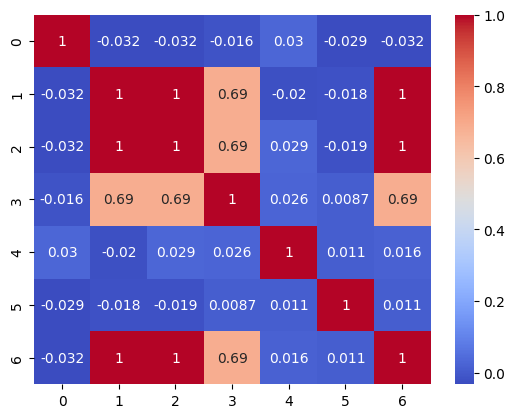

In [9]:
# examine relationships among five selected features, along with LogReturn and CloseLag1
XStudy = df.select('LogReturn','CloseLag1','CloseLag3','HMLLag1','OMCLag2','OMCLag3','CloseEMA8')

# prepare correlation heat map using seaborn
corrMatrix = XStudy.corr()
print(corrMatrix)
sns.heatmap(corrMatrix, cmap='coolwarm', annot=True)
plt.show()

In [11]:
# select subset of five columns as features
X = df.select('CloseLag3','HMLLag1','OMCLag2','OMCLag3','CloseEMA8')


### Define Cross-Validation Training and Test Sets

Recognizing that time series observations are not independent observations, we use Scikit-Learn TimeSeriesSplit for cross-validation.

This cross-validation object is a variation of multi-fold cross-validation for independent observations. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

Unlike cross-validation for independent observations, however, successive training sets are supersets of those that come before them. A listing of observation index numbers shows what this means for the time series market data in this demonstration.


In [12]:
# Splitting the datasets into train and test sets
# gap is the number of samples to exclude from 
# the end of each train set and before the next test set.
tscv = TimeSeriesSplit(gap=10, n_splits=5)

all_splits = list(tscv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

# examine the objects created for cross-validation splits
print("type(all_splits):", type(all_splits), " outer list length", len(all_splits))
print()
print("train_0 has",len(train_0),"with indices from ",min(train_0),"to",max(train_0))
print("test_0 has",len(test_0),"with indices from ",min(test_0),"to",max(test_0))
print()
print("train_1 has",len(train_1),"with indices from ",min(train_1),"to",max(train_1))
print("test_1 has",len(test_1),"with indices from ",min(test_1),"to",max(test_1))
print()
print("train_2 has",len(train_2),"with indices from ",min(train_2),"to",max(train_2))
print("test_2 has",len(test_2),"with indices from ",min(test_2),"to",max(test_2))
print()
print("train_3 has",len(train_3),"with indices from ",min(train_3),"to",max(train_3))
print("test_3 has",len(test_3),"with indices from ",min(test_3),"to",max(test_3))
print()
print("train_4 has",len(train_4),"with indices from ",min(train_4),"to",max(train_4))
print("test_4 has",len(test_4),"with indices from ",min(test_4),"to",max(test_4))

# to see all indices we can uncomment these statements
# print("elements of all_splits list of lists,\n shows index numbers for each the five lists")
# print(all_splits)

type(all_splits): <class 'list'>  outer list length 5

train_0 has 1041 with indices from  0 to 1040
test_0 has 1050 with indices from  1051 to 2100

train_1 has 2091 with indices from  0 to 2090
test_1 has 1050 with indices from  2101 to 3150

train_2 has 3141 with indices from  0 to 3140
test_2 has 1050 with indices from  3151 to 4200

train_3 has 4191 with indices from  0 to 4190
test_3 has 1050 with indices from  4201 to 5250

train_4 has 5241 with indices from  0 to 5240
test_4 has 1050 with indices from  5251 to 6300


### Define an Initial Classification Model to Be Evaluated¶

We again select gradient boosting from the XGBoost package, this time defining a classification model to be evaluated. Hyperparameters are retained at defauld settings, except for n_estimators.


In [13]:
model = XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=2025)

### Evaluate a Classification Model Within the Time Series Cross-Validation Design

Prior to executing a full-blown search for the "best" classification model, we test the cross-validation design on a binary classification model, revising code provided in online documentation for Scikit-Learn: [Time-related feature engineering](https://canvas.northwestern.edu/courses/240685/assignments/1626616?module_item_id=3530554). In particular, we define appropriate metrics for assessing classification performance.


In [14]:
def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["accuracy"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    accuracy = -cv_results["test_accuracy"]

    # print used in earlier testing
    # print(
    #    f"Mean Accuracy:     {-accuracy.mean():.3f} +/- {accuracy.std():.3f}\n"
    # )
    return (-accuracy.mean(), accuracy.std())
    
evaluate(model, X, y, cv=tscv, model_prop="n_estimators")

Mean model.n_estimators = 1000.0


(0.4973333333333333, 0.013634689651941536)

In [15]:
# print results from evaluate
accuracyMean, accuracyStd = evaluate(model, X, y, cv=tscv, model_prop="n_estimators")
print(
        f"Mean Accuracy:     {accuracyMean:.3f} +/- {accuracyStd:.3f}\n"
     )

Mean model.n_estimators = 1000.0
Mean Accuracy:     0.497 +/- 0.014



### Randomized Search for Hyperparameter Settings

We search for effective values on five XGBoost hyperparameters: max_depth, min_child_weight, subsample, learning_rate, and n_estimators.


In [16]:
# Randomized search to find the best set of hyperparameters

param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 1),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=2025)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100, # Number of parameter settings that are sampled.
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1 # Use all available cores
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

/Library/anaconda3/envs/tf_macos/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:15:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/anaconda3/envs/tf_macos/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:15:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/anaconda3/envs/tf_macos/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:15:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/anaconda3/envs/tf_macos/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:15:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warni

Best parameters: {'learning_rate': 0.10923820329666238, 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 638, 'subsample': 0.7190976331223788}
Best score: 0.5087619047619047


### Evaluate the Model

We define define an XGBoost subset model with these hyperparameter values and evaluate on the full data set.


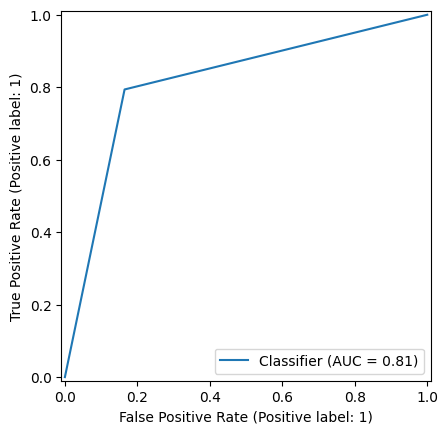

In [17]:
# final model evaluation
finalModel = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=2025,
                          max_depth = 9, min_child_weight = 9, subsample = 0.50, learning_rate = 0.09, n_estimators = 273)

finalModel.fit(X, y)
ypred = finalModel.predict(X)
RocCurveDisplay.from_predictions(y, ypred)

Confusion Matrix
[[2703  533]
 [ 632 2433]]


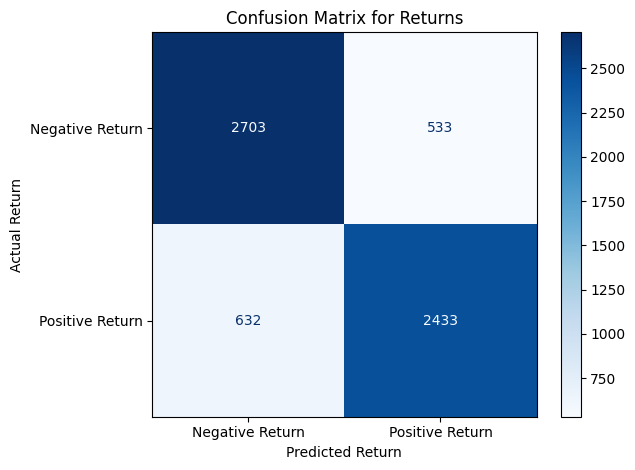

In [18]:
print("Confusion Matrix")
print(confusion_matrix(y, ypred))
disp = ConfusionMatrixDisplay.from_predictions(y, ypred,
                              display_labels =["Negative Return","Positive Return"],
                                              cmap = plt.cm.Blues)
plt.title("Confusion Matrix for Returns")
plt.xlabel("Predicted Return")
plt.ylabel("Actual Return")
plt.tight_layout()
plt.show() 

In [19]:
print(classification_report(y, ypred, labels = ["0","1"]))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      3236
           1       0.82      0.79      0.81      3065

   micro avg       0.82      0.82      0.82      6301
   macro avg       0.82      0.81      0.81      6301
weighted avg       0.82      0.82      0.81      6301

